In [1]:
#
import pandas
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot

#
# data = pandas.read_csv('./result.csv')
data = pandas.read_csv('./result_model_medieval.csv')
data = data.set_index('jx')
# GDP GS3 A091RC1Q027SBEA TLT IVV
"""
y = data['IVV'].values
mstl = MSTL(y, periods=[3, 6, 12, 36])  # 3 = quarter, 6 = semiyear, 12 = year, 36 = 3 years
res = mstl.fit()
resulted = pandas.DataFrame(data={'date': data.index.values,
                                  'origin': y,
                                  'seasonal_3': res.seasonal[:, 0],
                                  'seasonal_6': res.seasonal[:, 1],
                                  'seasonal_12': res.seasonal[:, 2],
                                  'seasonal_36': res.seasonal[:, 3],
                                  'trend': res.trend,
                                  'residual': res.resid, })

ax = resulted.plot(x='date', y=['origin', 'trend', 'residual'])
resulted.plot(x='date', y=['seasonal_3', 'seasonal_6', 'seasonal_12', 'seasonal_36'], secondary_y=True, ax=ax)
"""

# https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_filters.html#Christiano-Fitzgerald-approximate-band-pass-filter:-Inflation-and-Unemployment


# ['GS3', 'T10YIEM', 'USACPIALLMINMEI', 'KCFSI', 'MICH']    TLT_MEAN__pct
# ['TOTALSA', 'GDP', 'USACPIALLMINMEI', 'EMRATIO', 'KCFSI']
#
from functional import SomersD


def target_defined(y):
    if y < -0.015:
        return -1
    elif y < 0.015:
        return 0
    else:
        return 1


def score_defined(y):
    if y < -0.015:
        return -1
    elif y < 0.015:
        return 0
    else:
        return 1


data['target'] = data['IVV_MEAN__pct'].apply(func=target_defined)


<Axes: xlabel='jx'>

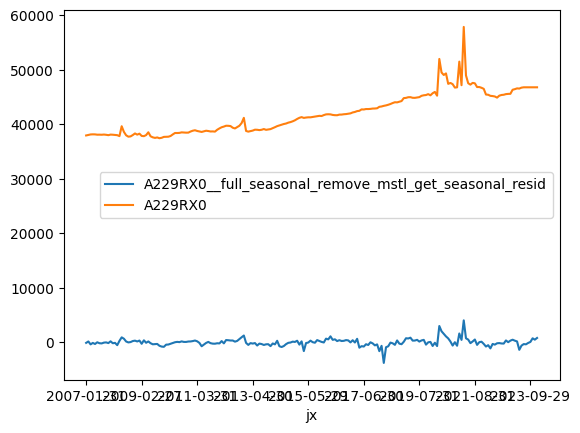

In [2]:
data[['A229RX0__full_seasonal_remove_mstl_get_seasonal_resid', 'A229RX0']].plot()

In [32]:
target = 'IVV_MEAN__pct'
# x_factors = pandas.Series(data=sds, index=data.columns.values).dropna().sort_values().iloc[-30:].index.values.tolist()
# x_factors = ['TLT__pct']
# '''
# x_factors = ['A229RX0__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function relative_q at 0x000001E0373857E0>']
driver_name = 'IRLTLT01USM156N__pct__full_binners_20_smile'
# driver_name = 'IVV__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function relative_q at 0x000001E0373857E0>'
# driver_name = 'GS1'
x_factors = [driver_name]
# '''
time_axis = data.index
time_sub_rate = 0.50
time_sub_replace = False
nt = int(time_axis.shape[0] * time_sub_rate)
n = 100
r2_trains, r2_tests = [], []
kt_trains, kt_tests = [], []
kt_trains_bin, kt_tests_bin = [], []
per_p_kst = []
for j in range(n):
    import numpy
    # ix_time = numpy.random.choice(time_axis.values, size=(nt,), replace=time_sub_replace)
    ixes = numpy.random.choice(list(range(time_axis.shape[0] - 1)), size=(nt,), replace=time_sub_replace)
    x_ix_train = time_axis.values[:-1][ixes]
    y_ix_train = time_axis.values[1:][ixes]
    left_ixes = [x for x in list(range(time_axis.shape[0] - 1)) if x not in ixes]
    x_ix_test = time_axis.values[:-1][left_ixes]
    y_ix_test = time_axis.values[1:][left_ixes]

    x_train = data.loc[x_ix_train, x_factors].values
    y_train = data.loc[y_ix_train, target].values
    x_test = data.loc[x_ix_test, x_factors].values
    y_test = data.loc[y_ix_test, target].values
    biny_train = data.loc[y_ix_train, 'target'].values
    biny_test = data.loc[y_ix_test, 'target'].values

    from sklearn.model_selection import train_test_split
    xxx_train, xxx_test, yyy_train, yyy_test = x_train, x_test, y_train, y_test
    from sklearn.preprocessing import StandardScaler
    sk = StandardScaler()
    xxx_train_st = sk.fit_transform(X=xxx_train)
    xxx_test_st = sk.transform(X=xxx_test)
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    m.fit(X=xxx_train_st, y=yyy_train)
    y_hat_train = m.predict(X=xxx_train_st)
    y_hat_test = m.predict(X=xxx_test_st)
    from sklearn.metrics import r2_score
    r2_train = r2_score(y_true=yyy_train, y_pred=y_hat_train)
    r2_test = r2_score(y_true=yyy_test, y_pred=y_hat_test)
    from scipy.stats import kendalltau
    kt_train = kendalltau(x=yyy_train, y=y_hat_train).statistic
    kt_test = kendalltau(x=yyy_test, y=y_hat_test).statistic
    y_hat_train_bin = pandas.Series(y_hat_train).apply(func=score_defined).values
    y_hat_test_bin = pandas.Series(y_hat_test).apply(func=score_defined).values
    kt_train_bin = kendalltau(x=biny_train, y=y_hat_train_bin).statistic
    kt_test_bin = kendalltau(x=biny_test, y=y_hat_test_bin).statistic
    from matplotlib import pyplot
    # fig, ax = pyplot.subplots(1, 2)
    # pandas.DataFrame(data={'error': yyy_train - y_hat_train}).hist(bins=20, ax=ax[0])
    # pandas.DataFrame(data={'error': yyy_test - y_hat_test}).hist(bins=20, ax=ax[1])
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)
    kt_trains.append(kt_train)
    kt_tests.append(kt_test)
    kt_trains_bin.append(kt_train_bin)
    kt_tests_bin.append(kt_test_bin)
    performance_over_time = pandas.DataFrame(data={'t': time_axis.values[1:][left_ixes], 'p': [kt_test] * len(left_ixes)})
    per_p_kst.append(performance_over_time)

In [33]:
pandas.Series(kt_tests).median(), pandas.Series(r2_test).median()

(0.09684889986906112, -0.3425436343341901)

<Axes: >

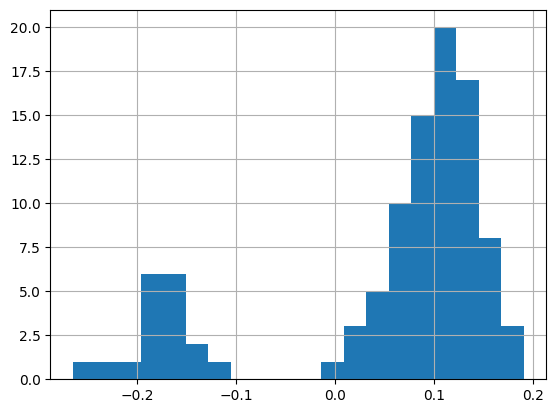

In [34]:
pandas.Series(kt_tests).hist(bins=20)

In [35]:
per_p_kst_c = pandas.concat(per_p_kst, axis=0, ignore_index=True)
per_p_kst_agg = per_p_kst_c.groupby(by='t')['p'].median()

In [36]:
per_p_kst_agg

t
2007-02-28    0.096849
2007-03-30    0.092716
2007-04-30    0.103331
2007-05-31    0.105876
2007-06-29    0.099850
                ...   
2023-08-31    0.102667
2023-09-29    0.102667
2023-10-31    0.091925
2023-11-30    0.105876
2023-12-15    0.092841
Name: p, Length: 203, dtype: float64

<Axes: xlabel='t'>

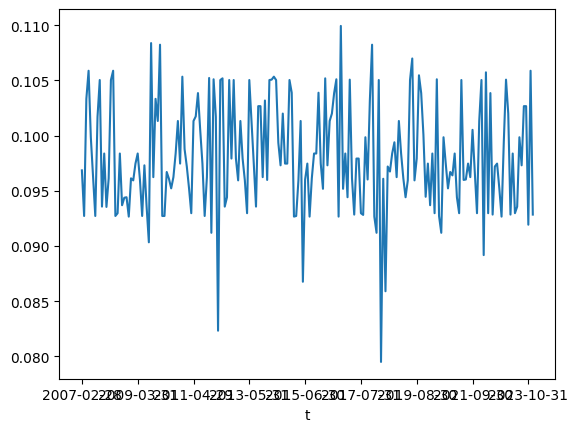

In [37]:
per_p_kst_agg.plot()

In [38]:

# driver_name = 'A229RX0__rolling_12__None__<function relative_q at 0x000001E0373857E0>'
import scipy

x_train = data.loc[x_ix_train, driver_name].values
y_train = data.loc[y_ix_train, target].values
x_test = data.loc[x_ix_test, driver_name].values
y_test = data.loc[y_ix_test, target].values

rs = scipy.stats.linregress(x=x_train, y=y_train)
r = x_train * rs.slope + rs.intercept

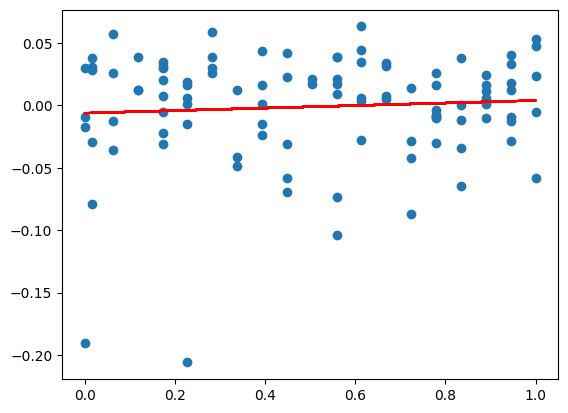

In [39]:
fig, ax = pyplot.subplots()
ax.scatter(x_train, y_train)
ax.plot(x_train, r, 'red')

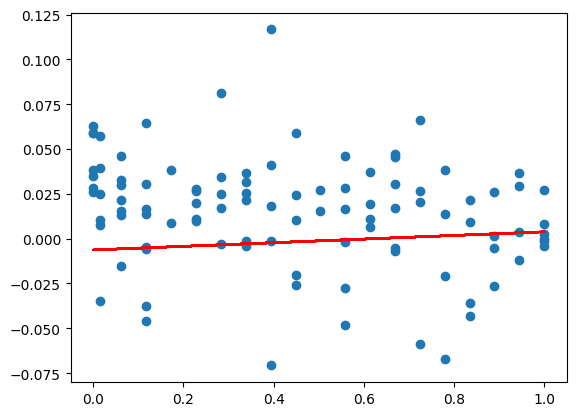

In [40]:
fig, ax = pyplot.subplots()
ax.scatter(x_test, y_test)
ax.plot(x_train, r, 'red')

In [12]:
data

,A091RC1Q027SBEA,A229RX0,A824RL1Q225SBEA,AAA,AIRRTMFMD11,AWHAERT,AWHMAN,BAA,BAMLC0A0CM,BAMLC0A0CMEY,...,TLT__full_binners_20_smile,TLT_MEAN__full_binners_20_smile,TOTALSA__full_binners_20_smile,TSIFRGHT__full_binners_20_smile,UNRATE__full_binners_20_smile,USACPIALLMINMEI__full_binners_20_smile,USEPUINDXM__full_binners_20_smile,USTRADE__full_binners_20_smile,W006RC1Q027SBEA__full_binners_20_smile,target
jx,,,,,,,,,,,,,,,,,,,,,
2007-01-31,396.009,37962.0,-3.3,5.40,3332574.0,31.7,41.0,6.34,1.297937,3.63,...,0.575604,0.000000,0.643303,0.014456,0.352941,1.0,0.000000,0.000570,0.001954,-1
2007-02-28,396.009,38055.0,-3.3,5.39,3374477.0,31.5,40.9,6.28,1.297937,3.63,...,0.000000,0.000000,0.760267,0.021684,0.294118,1.0,0.340586,0.000570,0.001954,0
2007-03-30,396.009,38145.0,-3.3,5.30,3383720.0,31.7,41.3,6.27,1.297937,3.63,...,0.575604,0.000000,0.526339,0.036140,0.294118,1.0,0.340586,0.000697,0.001954,0
2007-04-30,407.914,38167.0,9.3,5.47,3269567.0,31.6,41.3,6.39,1.297937,3.63,...,0.000000,0.582306,0.584821,0.014456,0.294118,1.0,0.340586,0.000633,0.001954,-1
2007-05-31,407.914,38156.0,9.3,5.47,3319743.0,31.7,41.1,6.39,1.297937,3.63,...,0.575604,0.582306,0.584821,0.021684,0.294118,1.0,0.000000,0.000697,0.001954,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,981.305,46795.0,8.0,4.66,3978655.0,29.9,40.6,5.74,1.220000,5.66,...,0.019759,0.020056,0.467857,0.122877,0.000000,0.0,0.057293,0.000824,0.005536,-1
2023-09-29,981.305,46795.0,8.0,4.66,3978655.0,29.8,40.6,5.74,1.240000,6.05,...,0.019759,0.013371,0.526339,0.122877,0.000000,0.0,0.057293,0.000887,0.005536,-1
2023-10-31,981.305,46795.0,8.0,4.66,3978655.0,29.8,40.6,5.74,1.320000,6.33,...,0.019759,0.582306,0.526339,0.122877,0.000000,0.0,0.057293,0.000887,0.005536,-1


In [2]:
target = 'IVV_MEAN__pct'
# x_factors = pandas.Series(data=sds, index=data.columns.values).dropna().sort_values().iloc[-30:].index.values.tolist()
# x_factors = ['TLT__pct']
# '''
x_factors = ['SPASTT01CNM657N__rolling_12__None__<function n_rate_conseq at 0x000001E037386290>',
 'IRLTLT01USM156N__pct__full_binners_20_smile',
 'IVV__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function rel_to_max at 0x000001E0373863B0>',
 'SPASTT01RUM657N__rolling_12__None__<function linear_slope at 0x000001E037386170>',
 'IVV__rolling_3__None__<function median_relative at 0x000001E037385630>',
 'GS1__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_max at 0x000001E0373863B0>',
 'IIPUSNETIQ__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01USM657N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'CPF3M__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'FDHBFRBN__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'SPASTT01RUM657N__full_seasonal_remove_mstl_get_seasonal_resid',
 'FLEXCPIM679SFRBATL__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_min at 0x000001E037386440>',
 'AWHMAN__rolling_6__None__<function relative_positive_pct at 0x000001E037386680>',
 'PMSAVE__rolling_12__None__<function linear_r2err at 0x000001E037386200>',
 'SPASTT01USM657N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function linear_r2err at 0x000001E037386200>',
 'PCU483111483111__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function median_relative at 0x000001E037385630>',
 'PSAVERT__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'INTDSRBRM193N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function median_relative at 0x000001E037385630>',
 'PCEPILFE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'FDHBFRBN__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function relative_q at 0x000001E0373857E0>',
 'SPASTT01USM657N',
 'SPASTT01CNM657N__pct__full_binners_20_perc',
 'IVV__rolling_3__None__<function linreg_relative at 0x000001E037385750>',
 'USTRADE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linear_r2err at 0x000001E037386200>',
 'MICH__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_max at 0x000001E0373863B0>',
 'UNRATE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linear_r2err at 0x000001E037386200>',
 'FRGSHPUSM649NCIS__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function ewm_1shock_relative_3 at 0x000001E037385870>',
 'GS20__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01CNM657N__rolling_6__None__<function n_rate_conseq at 0x000001E037386290>',
 'IVV_MEAN__pct__full_binners_20_perc',
 'IIPPORTAQ__rolling_3__None__<function rel_to_max at 0x000001E0373863B0>',
 'FLEXCPIM679SFRBATL__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'IVV__rolling_6__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01EZM657N__rolling_3__None__<function n_rate_full at 0x000001E037386320>',
 'A824RL1Q225SBEA__rolling_12__None__<function pct_std at 0x000001E0373864D0>',
 'IIPUSASSQ__rolling_12__None__<function ewm_1shock_relative_3 at 0x000001E037385870>',
 'RAILFRTCARLOADSD11__rolling_3__None__<function n_rate_full at 0x000001E037386320>']
# '''
time_axis = data.index
time_sub_rate = 0.50
time_sub_replace = False
nt = int(time_axis.shape[0] * time_sub_rate)
n = 100
r2_trains, r2_tests = [], []
kt_trains, kt_tests = [], []
kt_trains_bin, kt_tests_bin = [], []
per_p_kst = []
for j in range(n):
    import numpy
    # ix_time = numpy.random.choice(time_axis.values, size=(nt,), replace=time_sub_replace)
    ixes = numpy.random.choice(list(range(time_axis.shape[0] - 1)), size=(nt,), replace=time_sub_replace)
    x_ix_train = time_axis.values[:-1][ixes]
    y_ix_train = time_axis.values[1:][ixes]
    left_ixes = [x for x in list(range(time_axis.shape[0] - 1)) if x not in ixes]
    x_ix_test = time_axis.values[:-1][left_ixes]
    y_ix_test = time_axis.values[1:][left_ixes]

    x_train = data.loc[x_ix_train, x_factors].values
    y_train = data.loc[y_ix_train, target].values
    x_test = data.loc[x_ix_test, x_factors].values
    y_test = data.loc[y_ix_test, target].values
    biny_train = data.loc[y_ix_train, 'target'].values
    biny_test = data.loc[y_ix_test, 'target'].values

    from sklearn.model_selection import train_test_split
    xxx_train, xxx_test, yyy_train, yyy_test = x_train, x_test, y_train, y_test
    from sklearn.preprocessing import StandardScaler
    sk = StandardScaler()
    xxx_train_st = sk.fit_transform(X=xxx_train)
    xxx_test_st = sk.transform(X=xxx_test)
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    m.fit(X=xxx_train_st, y=yyy_train)
    y_hat_train = m.predict(X=xxx_train_st)
    y_hat_test = m.predict(X=xxx_test_st)
    from sklearn.metrics import r2_score
    r2_train = r2_score(y_true=yyy_train, y_pred=y_hat_train)
    r2_test = r2_score(y_true=yyy_test, y_pred=y_hat_test)
    from scipy.stats import kendalltau
    kt_train = kendalltau(x=yyy_train, y=y_hat_train).statistic
    kt_test = kendalltau(x=yyy_test, y=y_hat_test).statistic
    y_hat_train_bin = pandas.Series(y_hat_train).apply(func=score_defined).values
    y_hat_test_bin = pandas.Series(y_hat_test).apply(func=score_defined).values
    kt_train_bin = kendalltau(x=biny_train, y=y_hat_train_bin).statistic
    kt_test_bin = kendalltau(x=biny_test, y=y_hat_test_bin).statistic
    from matplotlib import pyplot
    # fig, ax = pyplot.subplots(1, 2)
    # pandas.DataFrame(data={'error': yyy_train - y_hat_train}).hist(bins=20, ax=ax[0])
    # pandas.DataFrame(data={'error': yyy_test - y_hat_test}).hist(bins=20, ax=ax[1])
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)
    kt_trains.append(kt_train)
    kt_tests.append(kt_test)
    kt_trains_bin.append(kt_train_bin)
    kt_tests_bin.append(kt_test_bin)
    performance_over_time = pandas.DataFrame(data={'t': time_axis.values[1:][left_ixes], 'p': [kt_test] * len(left_ixes)})
    per_p_kst.append(performance_over_time)

In [10]:
pandas.Series(kt_tests).median(), pandas.Series(r2_test).median()

(0.5241584158415842, 0.2856574558822049)

<Axes: >

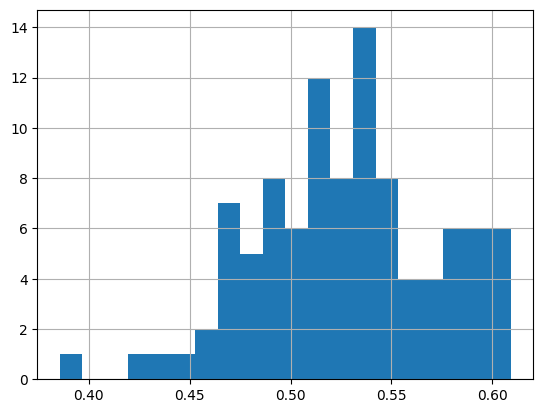

In [11]:
pandas.Series(kt_tests).hist(bins=20)

In [12]:
per_p_kst_c = pandas.concat(per_p_kst, axis=0, ignore_index=True)
per_p_kst_agg = per_p_kst_c.groupby(by='t')['p'].median()

In [13]:
per_p_kst_agg

t
2007-02-28    0.525743
2007-03-30    0.524950
2007-04-30    0.531881
2007-05-31    0.527129
2007-06-29    0.519208
                ...   
2023-08-31    0.522772
2023-09-29    0.527921
2023-10-31    0.532079
2023-11-30    0.522178
2023-12-15    0.532277
Name: p, Length: 203, dtype: float64

<Axes: xlabel='t'>

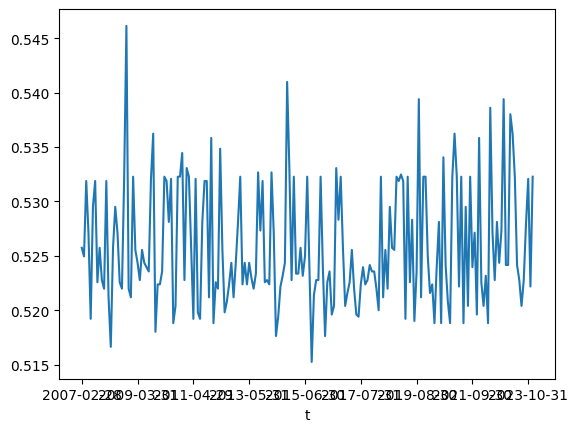

In [14]:
per_p_kst_agg.plot()

In [21]:
target = 'IVV_MEAN__pct'
# x_factors = pandas.Series(data=sds, index=data.columns.values).dropna().sort_values().iloc[-30:].index.values.tolist()
# x_factors = ['TLT__pct']
# '''
x_factors = ['SPASTT01CNM657N__rolling_12__None__<function n_rate_conseq at 0x000001E037386290>',
 'IRLTLT01USM156N__pct__full_binners_20_smile',
 'IVV__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function rel_to_max at 0x000001E0373863B0>',
 'SPASTT01RUM657N__rolling_12__None__<function linear_slope at 0x000001E037386170>',
 'IVV__rolling_3__None__<function median_relative at 0x000001E037385630>',
 'GS1__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_max at 0x000001E0373863B0>',
 'IIPUSNETIQ__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01USM657N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'CPF3M__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'FDHBFRBN__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'SPASTT01RUM657N__full_seasonal_remove_mstl_get_seasonal_resid',
 'FLEXCPIM679SFRBATL__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_min at 0x000001E037386440>',
 'AWHMAN__rolling_6__None__<function relative_positive_pct at 0x000001E037386680>',
 'PMSAVE__rolling_12__None__<function linear_r2err at 0x000001E037386200>',
 'SPASTT01USM657N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function linear_r2err at 0x000001E037386200>',
 'PCU483111483111__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function median_relative at 0x000001E037385630>',
 'PSAVERT__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'INTDSRBRM193N__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function median_relative at 0x000001E037385630>',
 'PCEPILFE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function ewm_1shock_relative_6 at 0x000001E037385900>',
 'FDHBFRBN__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function relative_q at 0x000001E0373857E0>',
 'SPASTT01USM657N',
 'SPASTT01CNM657N__pct__full_binners_20_perc',
 'IVV__rolling_3__None__<function linreg_relative at 0x000001E037385750>',
 'USTRADE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linear_r2err at 0x000001E037386200>',
 'MICH__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function rel_to_max at 0x000001E0373863B0>',
 'UNRATE__full_seasonal_remove_mstl_get_seasonal_resid__rolling_3__None__<function linear_r2err at 0x000001E037386200>',
 'FRGSHPUSM649NCIS__full_seasonal_remove_mstl_get_seasonal_resid__rolling_6__None__<function ewm_1shock_relative_3 at 0x000001E037385870>',
 'GS20__full_seasonal_remove_mstl_get_seasonal_resid__rolling_12__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01CNM657N__rolling_6__None__<function n_rate_conseq at 0x000001E037386290>',
 'IVV_MEAN__pct__full_binners_20_perc',
 'IIPPORTAQ__rolling_3__None__<function rel_to_max at 0x000001E0373863B0>',
 'FLEXCPIM679SFRBATL__rolling_6__None__<function relative_mean at 0x000001E0373865F0>',
 'IVV__rolling_6__None__<function linreg_relative at 0x000001E037385750>',
 'SPASTT01EZM657N__rolling_3__None__<function n_rate_full at 0x000001E037386320>',
 'A824RL1Q225SBEA__rolling_12__None__<function pct_std at 0x000001E0373864D0>',
 'IIPUSASSQ__rolling_12__None__<function ewm_1shock_relative_3 at 0x000001E037385870>',
 'RAILFRTCARLOADSD11__rolling_3__None__<function n_rate_full at 0x000001E037386320>']
# '''
time_axis = data.index
time_sub_rate = 0.50
time_sub_replace = False
nt = int(time_axis.shape[0] * time_sub_rate)
n = 10
r2_trains, r2_tests = [], []
kt_trains, kt_tests = [], []
kt_trains_bin, kt_tests_bin = [], []
per_p_kst = []
trains, tests = [], []
spaced = numpy.linspace(start=0, stop=1, num=n)
for j in range(n-2):
    start, mid, end = int(spaced[j] * (time_axis.shape[0] - 1)), int(spaced[j+1] * (time_axis.shape[0] - 1)), int(spaced[j+2] * (time_axis.shape[0] - 1))
    x_ix_train = time_axis.values[:-1][start:mid]
    y_ix_train = time_axis.values[1:][start:mid]
    x_ix_test = time_axis.values[:-1][mid:end]
    y_ix_test = time_axis.values[1:][mid:end]

    x_train = data.loc[x_ix_train, x_factors].values
    y_train = data.loc[y_ix_train, target].values
    x_test = data.loc[x_ix_test, x_factors].values
    y_test = data.loc[y_ix_test, target].values
    biny_train = data.loc[y_ix_train, 'target'].values
    biny_test = data.loc[y_ix_test, 'target'].values

    from sklearn.model_selection import train_test_split
    xxx_train, xxx_test, yyy_train, yyy_test = x_train, x_test, y_train, y_test
    from sklearn.preprocessing import StandardScaler
    sk = StandardScaler()
    xxx_train_st = sk.fit_transform(X=xxx_train)
    xxx_test_st = sk.transform(X=xxx_test)
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    m.fit(X=xxx_train_st, y=yyy_train)
    y_hat_train = m.predict(X=xxx_train_st)
    y_hat_test = m.predict(X=xxx_test_st)
    from sklearn.metrics import r2_score
    r2_train = r2_score(y_true=yyy_train, y_pred=y_hat_train)
    r2_test = r2_score(y_true=yyy_test, y_pred=y_hat_test)
    from scipy.stats import kendalltau
    kt_train = kendalltau(x=yyy_train, y=y_hat_train).statistic
    kt_test = kendalltau(x=yyy_test, y=y_hat_test).statistic
    y_hat_train_bin = pandas.Series(y_hat_train).apply(func=score_defined).values
    y_hat_test_bin = pandas.Series(y_hat_test).apply(func=score_defined).values
    kt_train_bin = kendalltau(x=biny_train, y=y_hat_train_bin).statistic
    kt_test_bin = kendalltau(x=biny_test, y=y_hat_test_bin).statistic
    from matplotlib import pyplot
    # fig, ax = pyplot.subplots(1, 2)
    # pandas.DataFrame(data={'error': yyy_train - y_hat_train}).hist(bins=20, ax=ax[0])
    # pandas.DataFrame(data={'error': yyy_test - y_hat_test}).hist(bins=20, ax=ax[1])
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)
    kt_trains.append(kt_train)
    kt_tests.append(kt_test)
    kt_trains_bin.append(kt_train_bin)
    kt_tests_bin.append(kt_test_bin)
    performance_over_time = pandas.DataFrame(data={'t': time_axis.values[1:][left_ixes], 'p': [kt_test] * len(left_ixes)})
    per_p_kst.append(performance_over_time)

    train_active = numpy.array([1 + (yyy_train[j] * y_hat_train_bin[j]) for j in range(yyy_train.shape[0])]).cumprod()
    train_passive = (yyy_train + 1).cumprod()

    test_active = numpy.array([1 + (yyy_test[j] * y_hat_test_bin[j]) for j in range(yyy_test.shape[0])]).cumprod()
    test_passive = (yyy_test + 1).cumprod()

    trains.append(pandas.DataFrame(data={'active': train_active, 'passive': train_passive}))
    tests.append(pandas.DataFrame(data={'active': test_active, 'passive': test_passive}))

<Axes: >

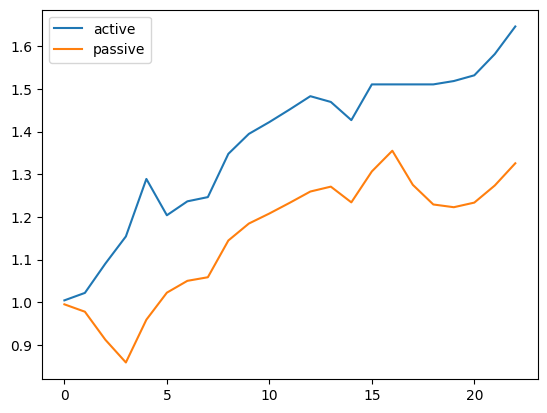

In [31]:
tests[0].plot()

In [3]:
target = 'IVV_MEAN__pct'
# x_factors = pandas.Series(data=sds, index=data.columns.values).dropna().sort_values().iloc[-30:].index.values.tolist()
# x_factors = ['TLT__pct']
# '''
x_factors = ['IVV__pct']
# '''
time_axis = data.index
time_sub_rate = 0.50
time_sub_replace = False
nt = int(time_axis.shape[0] * time_sub_rate)
n = 100
r2_trains, r2_tests = [], []
kt_trains, kt_tests = [], []
kt_trains_bin, kt_tests_bin = [], []
per_p_kst = []
for j in range(n):
    import numpy
    # ix_time = numpy.random.choice(time_axis.values, size=(nt,), replace=time_sub_replace)
    ixes = numpy.random.choice(list(range(time_axis.shape[0] - 1)), size=(nt,), replace=time_sub_replace)
    x_ix_train = time_axis.values[:-1][ixes]
    y_ix_train = time_axis.values[1:][ixes]
    left_ixes = [x for x in list(range(time_axis.shape[0] - 1)) if x not in ixes]
    x_ix_test = time_axis.values[:-1][left_ixes]
    y_ix_test = time_axis.values[1:][left_ixes]

    x_train = data.loc[x_ix_train, x_factors].values
    y_train = data.loc[y_ix_train, target].values
    x_test = data.loc[x_ix_test, x_factors].values
    y_test = data.loc[y_ix_test, target].values
    biny_train = data.loc[y_ix_train, 'target'].values
    biny_test = data.loc[y_ix_test, 'target'].values

    from sklearn.model_selection import train_test_split
    xxx_train, xxx_test, yyy_train, yyy_test = x_train, x_test, y_train, y_test
    from sklearn.preprocessing import StandardScaler
    sk = StandardScaler()
    xxx_train_st = sk.fit_transform(X=xxx_train)
    xxx_test_st = sk.transform(X=xxx_test)
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    m.fit(X=xxx_train_st, y=yyy_train)
    y_hat_train = m.predict(X=xxx_train_st)
    y_hat_test = m.predict(X=xxx_test_st)
    from sklearn.metrics import r2_score
    r2_train = r2_score(y_true=yyy_train, y_pred=y_hat_train)
    r2_test = r2_score(y_true=yyy_test, y_pred=y_hat_test)
    from scipy.stats import kendalltau
    kt_train = kendalltau(x=yyy_train, y=y_hat_train).statistic
    kt_test = kendalltau(x=yyy_test, y=y_hat_test).statistic
    y_hat_train_bin = pandas.Series(y_hat_train).apply(func=score_defined).values
    y_hat_test_bin = pandas.Series(y_hat_test).apply(func=score_defined).values
    kt_train_bin = kendalltau(x=biny_train, y=y_hat_train_bin).statistic
    kt_test_bin = kendalltau(x=biny_test, y=y_hat_test_bin).statistic
    from matplotlib import pyplot
    # fig, ax = pyplot.subplots(1, 2)
    # pandas.DataFrame(data={'error': yyy_train - y_hat_train}).hist(bins=20, ax=ax[0])
    # pandas.DataFrame(data={'error': yyy_test - y_hat_test}).hist(bins=20, ax=ax[1])
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)
    kt_trains.append(kt_train)
    kt_tests.append(kt_test)
    kt_trains_bin.append(kt_train_bin)
    kt_tests_bin.append(kt_test_bin)
    performance_over_time = pandas.DataFrame(data={'t': left_ixes, 'p': kt_test * len(left_ixes)})
    per_p_kst.append(performance_over_time)

In [4]:
pandas.Series(kt_tests).median(), pandas.Series(r2_test).median()

(0.33673386049231513, 0.250511706087475)

<Axes: >

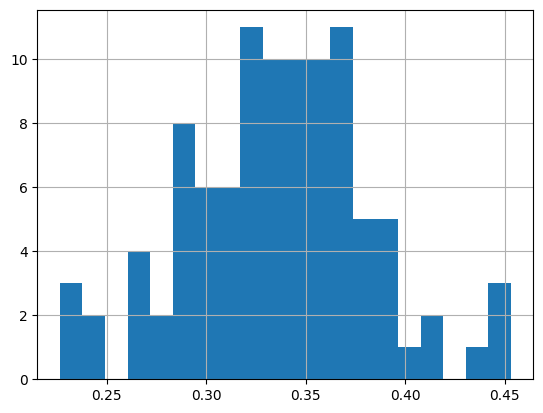

In [5]:
pandas.Series(kt_tests).hist(bins=20)

In [6]:
target = 'IVV_MEAN__pct'
# x_factors = pandas.Series(data=sds, index=data.columns.values).dropna().sort_values().iloc[-30:].index.values.tolist()
# x_factors = ['TLT__pct']
# '''
x_factors = 'IVV_MEAN__pct'  # HOHOHO
# '''
time_axis = data.index
time_sub_rate = 0.50
time_sub_replace = False
nt = int(time_axis.shape[0] * time_sub_rate)
n = 100
r2_trains, r2_tests = [], []
kt_trains, kt_tests = [], []
kt_trains_bin, kt_tests_bin = [], []
per_p_kst = []
for j in range(n):
    import numpy
    # ix_time = numpy.random.choice(time_axis.values, size=(nt,), replace=time_sub_replace)
    ixes = numpy.random.choice(list(range(time_axis.shape[0] - 1)), size=(nt,), replace=time_sub_replace)
    x_ix_train = time_axis.values[:-1][ixes]
    y_ix_train = time_axis.values[1:][ixes]
    left_ixes = [x for x in list(range(time_axis.shape[0] - 1)) if x not in ixes]
    x_ix_test = time_axis.values[:-1][left_ixes]
    y_ix_test = time_axis.values[1:][left_ixes]

    x_train = data.loc[x_ix_train, x_factors].values
    y_train = data.loc[y_ix_train, target].values
    x_test = data.loc[x_ix_test, x_factors].values
    y_test = data.loc[y_ix_test, target].values
    biny_train = data.loc[y_ix_train, 'target'].values
    biny_test = data.loc[y_ix_test, 'target'].values

    xxx_train, xxx_test, yyy_train, yyy_test = x_train, x_test, y_train, y_test
    y_hat_train = x_train
    y_hat_test = x_test
    from sklearn.metrics import r2_score
    r2_train = r2_score(y_true=yyy_train, y_pred=y_hat_train)
    r2_test = r2_score(y_true=yyy_test, y_pred=y_hat_test)
    from scipy.stats import kendalltau
    kt_train = kendalltau(x=yyy_train, y=y_hat_train).statistic
    kt_test = kendalltau(x=yyy_test, y=y_hat_test).statistic
    from matplotlib import pyplot
    # fig, ax = pyplot.subplots(1, 2)
    # pandas.DataFrame(data={'error': yyy_train - y_hat_train}).hist(bins=20, ax=ax[0])
    # pandas.DataFrame(data={'error': yyy_test - y_hat_test}).hist(bins=20, ax=ax[1])
    r2_trains.append(r2_train)
    r2_tests.append(r2_test)
    kt_trains.append(kt_train)
    kt_tests.append(kt_test)
    performance_over_time = pandas.DataFrame(data={'t': left_ixes, 'p': kt_test * len(left_ixes)})
    per_p_kst.append(performance_over_time)

In [7]:
pandas.Series(kt_tests).median(), pandas.Series(r2_test).median()

(0.10435643564356438, -0.7804038929985937)

<Axes: >

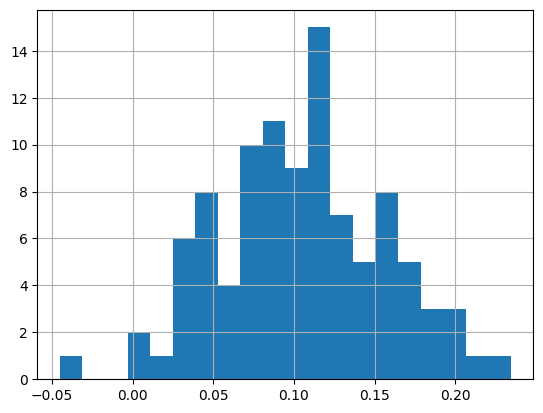

In [8]:
pandas.Series(kt_tests).hist(bins=20)